# Evasion exercise

In this notebook, you will use SecML to implement adversarial attacks against a given neural network.  
   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fabiogueunige/Trustworthy/blob/HEAD/02B-EvasionIMPORTANT.ipynb)

In [ ]:
# foolbox is tool that give me the instrument for do an attack to M.L. model
# secMl is a library that give me the instrument for do an attack to M.L. model
try:
    import secml
except ImportError:
    %pip install secml[foolbox]

### simple neuronal network creation

linear matrices to compute scalar product  
Relu activation function to inject some non linearities

In [ ]:
# deep neual network model
# pytorch is the tool usefull for doing this
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch

random_state = 999


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x)) #relu activatio function, piece-wise linear function
        x = self.fc2(x)
        return x

# to wrap the classifier
n_features = 2
n_classes = 3

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

loss_function = nn.CrossEntropyLoss() # define the loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=loss_function,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

Dataset is composed by:  
X = samples  
Y = labels

In [ ]:
n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # centers of the clusters
cluster_std = 0.8  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

# for the part of the centers, I can pass a number to the function and itself it statiate 3 randomo center for the blobs, in this case I have te centers jet
# .load() is a constructor
# creates some datas
# load actually creates the dataset
dataset =  CDLRandomBlobs(n_samples, n_features, centers, cluster_std).load() # TODO  instantiate a CDLRandomBlobs dataset
n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)


### To create the classifier this is the right way

Giving the training samples and the training labels

In [ ]:
# now we want to fit the data, the cassifiers is created jet
# X: CArray used for training with shape (n_samples, n_features)
# Y: CArray array with shape(n_samples) containing the class labels
# return the classified dataset
clf.fit(tr.X, tr.Y)  # TODO fit the classifier using SecML
# to predict obviously need the test set
y_pred, scores = clf.predict(ts.X, True) # TODO  compute predictions on test set

print(scores)

In [ ]:
# can have very different metrics to visualize the performance of the model
from secml.ml.peval.metrics import CMetricAccuracy, CMetricPrecision, CMetricRecall, CMetricF1

# compute metrics
accuracy = CMetricAccuracy().performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(accuracy))
print("F1 on test set: {:.2%}".format(CMetricF1().performance_score(y_true=ts.Y, y_pred=y_pred)))
print("Recall on test set: {:.2%}".format(CMetricRecall().performance_score(y_true=ts.Y, y_pred=y_pred)))
print("Precision on test set: {:.2%}".format(CMetricPrecision().performance_score(y_true=ts.Y, y_pred=y_pred)))

# the decicion function is not for sure probability, but just numbers that must be interpreted

CArray([[ 5.533012 -2.752163 -2.329449]
 [-0.572328 -2.611493  3.891158]
 [-4.493112  5.038597  0.360886]
 ...
 [ 3.92882  -2.785305 -0.632222]
 [-2.440794 -0.499     3.73648 ]
 [ 4.571342 -2.690849 -1.397853]])
Accuracy on test set: 99.60%
F1 on test set: 99.60%
Recall on test set: 99.60%
Precision on test set: 99.60%


In [ ]:
# cell used for print
# we need to visualize the test set for out attack
# we print also the decision boundary of the model
%matplotlib inline
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=200)
fig.show()

## Attack with PGDL1, PGDL2, PGDLinf

In [ ]:
# import the attack we want to see
#from secml.adv.attacks.evasion import CFoolboxPGDLinf  # infinite import

### Attack with PGDL1 (TARGETED ATTACK)

In [ ]:
# remember the import!!
from secml.adv.attacks.evasion import CFoolboxPGDL1
y_target = 0
index = 0
x0, y0 = ts.X[index, :], ts.Y[index]

# Attack parameters
lb = 0  # lower bound of the input space
ub = 1  # upper bound of the input space
epsilon = 0.1 # perturbation budget
abs_stepsize = 0.01  # stepsize of the attack (absolute)
steps = 100  # number of iterations
# relative stepsize, percantage of perturbation that I want to use at each iteration, I can decide ot use this or the absolute abs_stepsize
# in our case we skip this parameter
# the second parametre is the target class I want to reach (for targeted classification or untargeted)
# requires if to use the relative or absolute stepsize
pgd_attack = CFoolboxPGDL1(clf, y_target, lb, ub, epsilon, abs_stepsize =abs_stepsize, steps=steps) # TODO: instantiate the CFoolboxPGDL1 to create an untargeted attack (y_target = None) against the trained clf

# the attack return 4 thinks:
# - y_adv_pred: predicted label after attack
# - adv_scores: scores (don't use usually)
# - adv_ds_pgd: dataset containing the adversarial example
# - opt_loss_val: optimization of the loss function ( don't use usually)
y_adv_pred, adv_scores , adv_ds_pgd, opt_loss_val = pgd_attack.run(x0, y0) # TODO: run the attack on the sample (x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_adv_pred.item())

In [ ]:
# plot path of the attack
# check if the library is the right one (so the import)
from secml.optim.constraints.c_constraint_l1 import CConstraintL1

fig = CFigure()
fig.sp.plot_path(pgd_attack.x_seq) #all the samples computed during atatck
fig.sp.plot_constraint(CConstraintL1(epsilon))
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=50)

### Attack with PGDL2 (untargeted)

In [ ]:
# remember the import!!
from secml.adv.attacks.evasion import CFoolboxPGDL2

y_target = None # UNTARGETD ATTACK
index = 0
x0, y0 = ts.X[index, :], ts.Y[index]

# Attack parameters
lb = 0  # lower bound of the input space
ub = 1  # upper bound of the input space
epsilon = 0.3 # perturbation budget
abs_stepsize = 0.01  # stepsize of the attack
steps = 100  # number of iterations
# relative stepsize, percantage of perturbation that I want to use at each iteration, I can decide ot use this or the absolute abs_stepsize
# in our case we skip this parameter
# the second parametre is the target class I want to reach
pgd_attack = CFoolboxPGDL2(clf, y_target, lb, ub, epsilon, abs_stepsize =abs_stepsize, steps=steps) # TODO: instantiate the CFoolboxPGDL2 to create an untargeted attack against the trained clf

# the attack return 4 thinks:
# - y_adv_pred: predicted label after attack
# - adv_scores: scores (don't use usually)
# - adv_ds_pgd: dataset containing the adversarial example
# - opt_loss_val: optimization of the loss function ( don't use usually)
y_adv_pred, adv_scores , adv_ds_pgd, opt_loss_val = pgd_attack.run(x0, y0) # TODO: run the attack on the sample (x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_adv_pred.item())

Original x0 label:  0
Adversarial example label (PGD-L2):  0


In [ ]:
from secml.optim.constraints.c_constraint_l2 import CConstraintL2

fig = CFigure()
fig.sp.plot_path(pgd_attack.x_seq) #all the samples computed during atatck
fig.sp.plot_constraint(CConstraintL2(epsilon))
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=50)

# Security Evaluations

Testing one single perturbation budget is not enough to understand the robustness of your machine learning classifier.
Hence, a fair analysis consists of a *security evaluation* of the model, by considering more perturbation budgets, and hence quantify the performance of the target systematically against stronger and stronger attacks.
To do so, we first set the number of parameters we want to test (in this case, `epsilons`) and we compute attacks by varying the perturbation size.

Using the same attack of L2 norm doing security evaluation  
SECURITY EVALUATION ALWAYS UNTARGETED

In [ ]:
# create list of epsilons to use in the security evaluation (may need more)
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]
robust_accuracies = []
y_target = None # always for security evaluation
metric = CMetricAccuracy()
# goal is to use all the ts, so use all the 30 samples
# for save-time try now to evaluate only one 10 samples
# X, y = ts.X[:10, :], ts.Y[:10] (smaller dataset)
X, y = ts.X[:, :], ts.Y[:] # ALWAYS DO ATTACK ON ALL TEST SET (LOT OF TIME)

for eps in epsilons:
    # TODO: instantiate the CFoolboxPGDL2 to create an untargeted attack (y_target = None) against the trained clf
    # NOTE: security evaluation attack must to be untarget, so can reach all the class it wants
    # NOTE: use None ad the target atatch want to reach
    # NOTE: the attack for security evaluation must't have random star, put the random_start = False, if not we will have a odd function
    # NOTE: remember that the parameters are very important to set for have a good security evaluation
    pgd_attack = pgd_attack = CFoolboxPGDL2(clf, y_target, lb, ub, epsilon, abs_stepsize=abs_stepsize, steps=100, random_start=False)
    y_adv_pred, _, _, _ = pgd_attack.run(X, y) # TODO: run the attack on the X, y set of samples
    accuracy = metric.performance_score(y, y_adv_pred)
    robust_accuracies.append(accuracy)

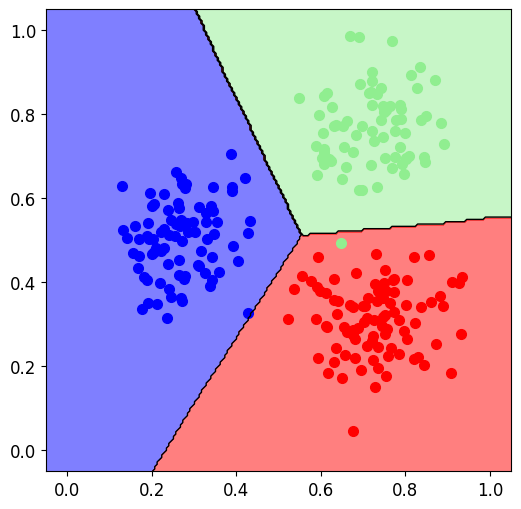

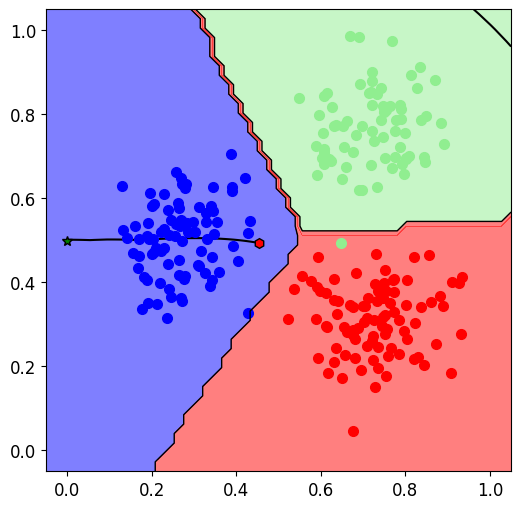

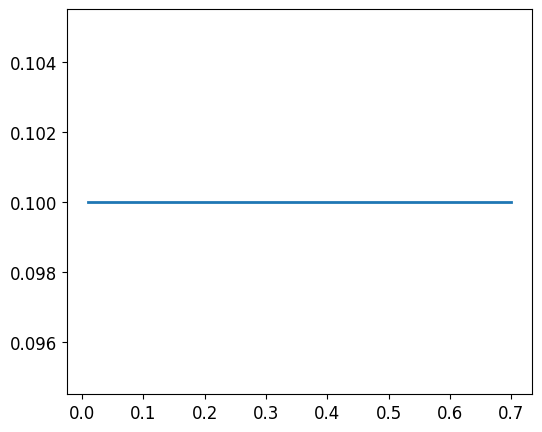

In [ ]:
%matplotlib inline
fig = CFigure(height=5, width=6)
fig.sp.plot(epsilons, robust_accuracies)
fig.show()

The security evaluation has always to decrease (flat means too low samples or bas security)